<a href="https://colab.research.google.com/github/abhinava-sai/Automated-Diabetic-foot-ulcer-detection/blob/main/DFU_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, concatenate, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import cv2
import tensorflow as t

## Step 1: Data Generators with Augmentation

In [ ]:
# Step 1: Data Generators
print("Loading Data...")
datagen = ImageDataGenerator(
    rescale=1.0/255, rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True, zoom_range=0.2
)
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Roboflow_Dataset/train',
    target_size=(224, 224), batch_size=32, class_mode='binary'
)
val_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Roboflow_Dataset/valid',
    target_size=(224, 224), batch_size=32, class_mode='binary'
)
test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    '/content/drive/MyDrive/Roboflow_Dataset/test',
    target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)
print("Data Generators Ready!")

Loading Data...
Found 675 images belonging to 2 classes.
Found 273 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Data Generators Ready!


In [ ]:
# Step 2: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
callbacks = [early_stopping, lr_scheduler]

In [ ]:
# Step 3: Define Models with Proper Input Shape Handling
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def add_classification_head(base_model):
    """Add a more complex classification head to the base model."""
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary Classification
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define Base Models (No pooling, Fix input_shape)
models = {
    'EfficientNet': lambda: EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'VGG16': lambda: VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'ResNet50': lambda: ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'GoogleNet': lambda: InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

# Fixed Hybrid Model
def build_hybrid_model():
    input_tensor = Input(shape=(224, 224, 3))

    # Load Pretrained Models (without input_tensor)
    eff = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))(input_tensor)
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))(input_tensor)
    res = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))(input_tensor)

    # Global Pooling to Flatten Outputs
    merged = concatenate([
        GlobalAveragePooling2D()(eff),
        GlobalAveragePooling2D()(vgg),
        GlobalAveragePooling2D()(res)
    ])

    # Classification Head
    x = Dense(512, activation='relu')(merged)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary Classification

    # Final Model
    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

print("All Models Defined!")

All Models Defined!


In [ ]:
# Step 4: Filter only Hybrid and Ensemble CNN models
selected_models = {
    'Hybrid': build_hybrid_model
}


In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_generator.classes)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.9926470588235294), 1: np.float64(1.007462686567164)}


In [ ]:
# Step 5: Train Models with Fine-Tuning
for model_name, model_fn in models.items():
    print(f"Training {model_name}...")

    # Load base model & add classification head
    base_model = model_fn()
    model = add_classification_head(base_model)

    # Initial Training (Freeze Pretrained Layers)
    for layer in base_model.layers:
        layer.trainable = False

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        callbacks=callbacks,
        class_weight=class_weights_dict
    )

    # Fine-Tuning (Unfreeze Pretrained Layers)
    for layer in base_model.layers:
        layer.trainable = True

    fine_tune_history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=45,  # Continue training for 45 more epochs
        callbacks=callbacks,
        class_weight=class_weights_dict
    )

    # Save trained model
    model.save(f'/content/drive/MyDrive/{model_name}_dfu_model.h5')
    print(f"{model_name} training completed and model saved!\n")


Training EfficientNet...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 418s 18s/step - accuracy: 0.5185 - loss: 0.6924 - val_accuracy: 0.5128 - val_loss: 0.6930 - learning_rate: 1.0000e-05
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 752ms/step - accuracy: 0.4599 - loss: 0.7209 - val_accuracy: 0.5128 - val_loss: 0.6929 - learning_rate: 1.0000e-05
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 782ms/step - accuracy: 0.5461 - loss: 0.6872 - val_accuracy: 0.5128 - val_loss: 0.6928 - learning_rate: 1.0000e-05
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 694ms/step - accuracy: 0.5501 - loss: 0.6968 - val_accuracy: 0.5128 - val_loss: 0.6927 - learning_rate: 1.0000e-05
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.4790 - loss: 0.7057
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 688ms/step - accuracy: 0.4789 - loss: 0.7056 - val_accuracy: 0.5128 - val_loss: 0.6929 - learning_rate: 1.0000e-05
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 721ms/step - accuracy: 

EfficientNet training completed and model saved!

Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4669 - loss: 0.7866 - val_accuracy: 0.7436 - val_loss: 0.6778 - learning_rate: 1.0000e-05
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 739ms/step - accuracy: 0.4902 - loss: 0.7306 - val_accuracy: 0.7875 - val_loss: 0.6625 - learning_rate: 1.0000e-05
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 739ms/step - accuracy: 0.5435 - loss: 0.7058 - val_accuracy: 0.8022 - val_loss: 0.6481 - learning_rate: 1.0000e-05
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 733ms/step - accuracy: 0.5662 - loss: 0.6908 - val_accuracy: 0.8168 - val_loss: 0.6362 - learning_rate: 1.0000e-05
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 821ms/step - accuracy: 0.5831 - loss: 0.6791 - val_accuracy: 0.8498 - val_loss: 0.6263 - learning_rate: 1.0000e-05
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 740ms/step - accuracy: 0.5352 - loss: 0.6941 - val_accura

VGG16 training completed and model saved!

Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5331 - loss: 0.8855 - val_accuracy: 0.5128 - val_loss: 0.6966 - learning_rate: 1.0000e-05
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 738ms/step - accuracy: 0.4744 - loss: 0.8874 - val_accuracy: 0.5128 - val_loss: 0.6828 - learning_rate: 1.0000e-05
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 751ms/step - accuracy: 0.5212 - loss: 0.8263 - val_accuracy: 0.4945 - val_loss: 0.6871 - learning_rate: 1.0000e-05
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.4871 - loss: 0.8316
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 707ms/step - accuracy: 0.4883 - loss: 0.8307 - val_accuracy: 0.4872 - val_loss: 0.6902 - learning_rate: 1.0000e-05
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 756ms/step - accuracy: 0.5567 - loss: 0.7991 - val_accuracy: 0.4872

ResNet50 training completed and model saved!

Training GoogleNet...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5106 - loss: 1.1008 - val_accuracy: 0.6410 - val_loss: 0.6611 - learning_rate: 1.0000e-05
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 720ms/step - accuracy: 0.5606 - loss: 0.8044 - val_accuracy: 0.7839 - val_loss: 0.5585 - learning_rate: 1.0000e-05
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 741ms/step - accuracy: 0.6314 - loss: 0.6493 - val_accuracy: 0.7070 - val_loss: 0.5284 - learning_rate: 1.0000e-05
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 710ms/step - accuracy: 0.6546 - loss: 0.6286 - val_accuracy: 0.8425 - val_loss: 0.4749 - learning_rate: 1.0000e-05
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 715ms/step - accuracy: 0.6656 - loss: 0.5962 - val_accuracy: 0.8352 - val_loss: 0.4410 - learning_rate: 1.0000e-05
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 714ms/step - accuracy: 0.7536 - loss: 0.4983 - val_accura

GoogleNet training completed and model saved!



In [ ]:
# Step 6: Train Hybrid
for model_name, model_fn in selected_models.items():
    print(f"Training {model_name}...")

    # Build and train the model
    model = model_fn()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=45,
        callbacks=callbacks,
        class_weight=class_weights_dict
    )

    # Save the trained model
    model.save(f'/content/drive/MyDrive/{model_name}_dfu_model.h5')
    print(f"{model_name} training completed and model saved!\n")


Training Hybrid...
Epoch 1/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step - accuracy: 0.5764 - loss: 0.7491 - val_accuracy: 0.5275 - val_loss: 0.6403 - learning_rate: 1.0000e-05
Epoch 2/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8320 - loss: 0.4104 - val_accuracy: 0.9634 - val_loss: 0.3201 - learning_rate: 1.0000e-05
Epoch 3/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9332 - loss: 0.1792 - val_accuracy: 0.9231 - val_loss: 0.2199 - learning_rate: 1.0000e-05
Epoch 4/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9648 - loss: 0.1105 - val_accuracy: 0.9707 - val_loss: 0.1172 - learning_rate: 1.0000e-05
Epoch 5/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9745 - loss: 0.0788 - val_accuracy: 0.9524 - val_loss: 0.1271 - learning_rate: 1.0000e-05
Epoch 6/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9613 - loss: 0.1028 - val_accuracy: 0.9744 - val_loss: 0.0989 - learning_rate: 1.0000e-05
Epoch 7/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accu

Hybrid training completed and model saved!



In [ ]:
# Step 7: Post-Training Evaluation and Interpretability

# List of models including Hybrid and Ensemble CNN
models = ["EfficientNet", "VGG16", "ResNet50", "GoogleNet", "Hybrid"]

# Function to plot AUC-ROC Curve
def plot_auc_roc(model, test_generator, model_name):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator).ravel()
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - AUC-ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# Function to plot Precision-Recall Curve
def plot_precision_recall(model, test_generator, model_name):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator).ravel()
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)

    plt.figure()
    plt.plot(recall, precision, color='purple', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.show()

In [ ]:
# Data Augmentation Visualization
import matplotlib.pyplot as plt

def visualize_augmentation(generator, num_images=5):
    """Visualize augmented images from the data generator."""
    # Get a batch of images and labels
    images, labels = next(iter(generator))

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f'Label: {"Ulcer" if labels[i] > 0.5 else "Healthy"}')

    plt.show()

Evaluating EfficientNet...


4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 12s/step


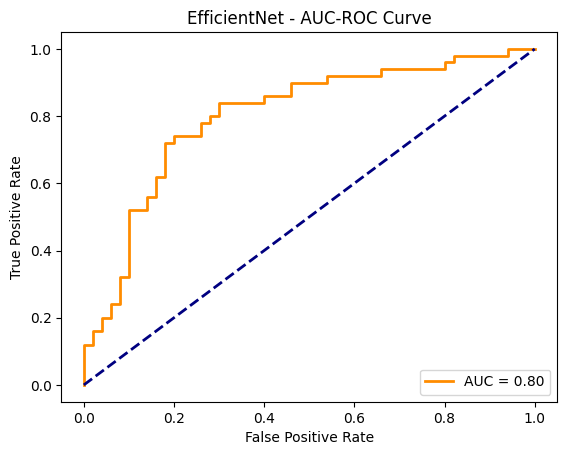

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


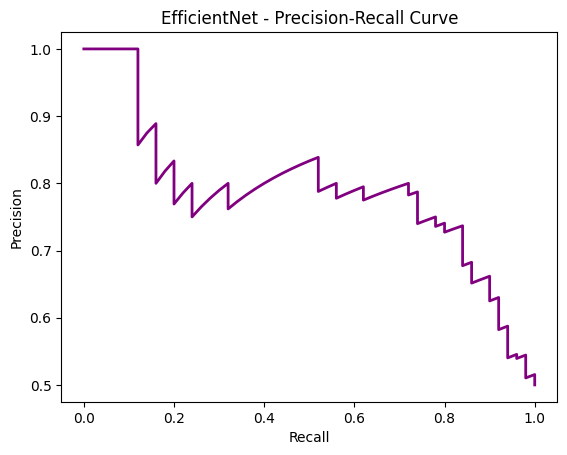

EfficientNet evaluation completed.

Evaluating VGG16...


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


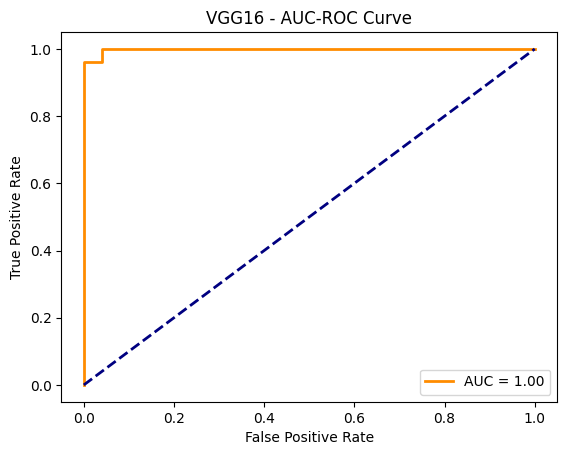

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


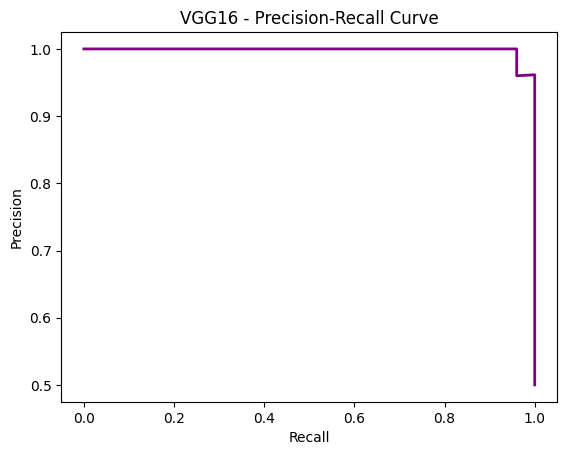

VGG16 evaluation completed.

Evaluating ResNet50...


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


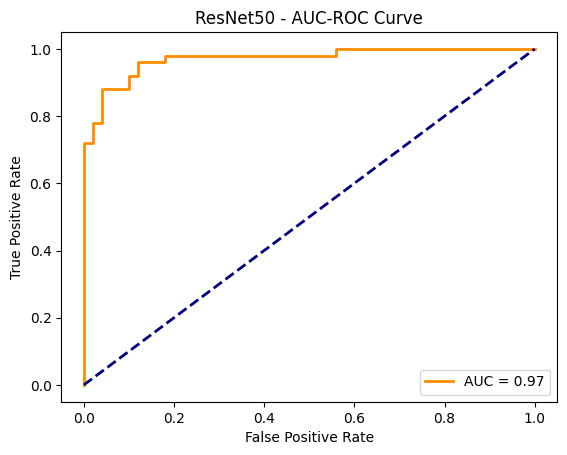

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


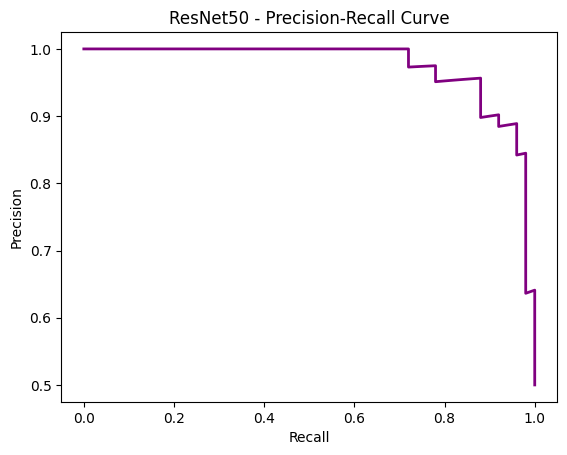

ResNet50 evaluation completed.

Evaluating GoogleNet...


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


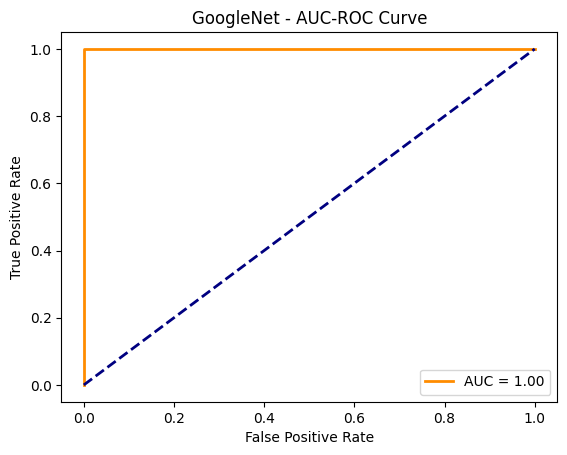

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


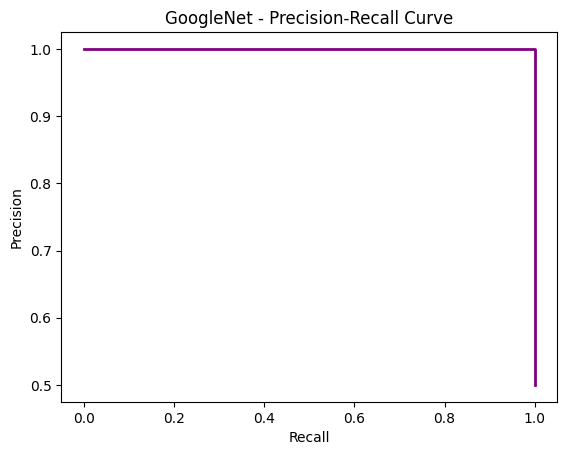

GoogleNet evaluation completed.

Evaluating Hybrid...


4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step


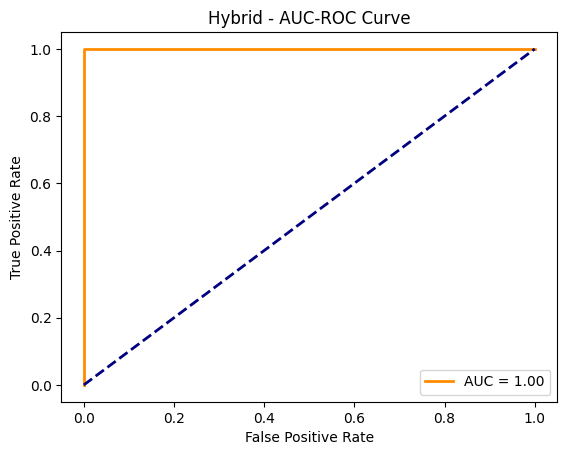

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


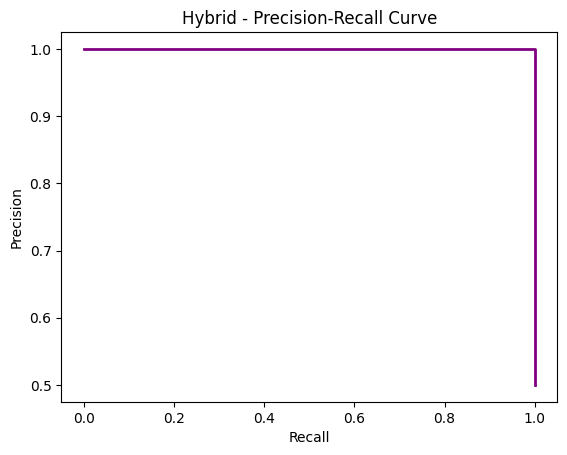

Hybrid evaluation completed.



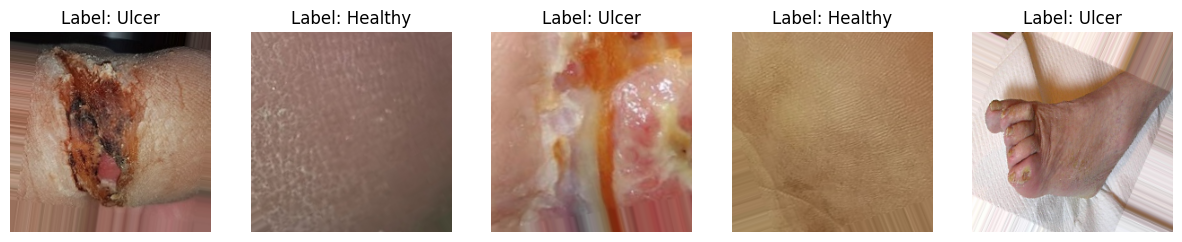

Post-training evaluation and visualizations completed!


In [ ]:
# Apply Evaluation and Interpretability Steps
for model_name in models:
    print(f"Evaluating {model_name}...")
    model = tf.keras.models.load_model(f'/content/drive/MyDrive/{model_name}_dfu_model.h5')

    # Evaluate with additional metrics
    plot_auc_roc(model, test_generator, model_name)
    plot_precision_recall(model, test_generator, model_name)


    print(f"{model_name} evaluation completed.\n")

# Visualize Data Augmentation
visualize_augmentation(train_generator)

print("Post-training evaluation and visualizations completed!")

In [ ]:
# Step 8: Model Performance Summary

def evaluate_model(model, test_generator, model_name):
    y_true = test_generator.classes
    y_pred = (model.predict(test_generator) > 0.5).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)

    # Extract relevant metrics
    accuracy = report['accuracy']
    precision = report['1']['precision'] if '1' in report else 0.0
    recall = report['1']['recall'] if '1' in report else 0.0
    f1_score = report['1']['f1-score'] if '1' in report else 0.0

    print(f"{model_name} Evaluation Completed:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}\n")

    return {
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1_score, 4)
    }

# Evaluate all models and create a results table
results = []

for model_name in models:
    model_path = f'/content/drive/MyDrive/{model_name}_dfu_model.h5'
    if os.path.exists(model_path):
        model = tf.keras.models.load_model(model_path)
        results.append(evaluate_model(model, test_generator, model_name))
    else:
        print(f"Model {model_name} not found. Skipping...")

# Display Results as a DataFrame
results_df = pd.DataFrame(results)
print("Model Evaluation Results:")
print(results_df)

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
EfficientNet Evaluation Completed:
Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1-Score: 0.6667



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step
VGG16 Evaluation Completed:
Accuracy: 0.9500, Precision: 1.0000, Recall: 0.9000, F1-Score: 0.9474



4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
ResNet50 Evaluation Completed:
Accuracy: 0.9000, Precision: 0.8571, Recall: 0.9600, F1-Score: 0.9057



4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
GoogleNet Evaluation Completed:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000



4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
Hybrid Evaluation Completed:
Accuracy: 0.9800, Precision: 1.0000, Recall: 0.9600, F1-Score: 0.9796

Model Evaluation Results:
          Model  Accuracy  Precision  Recall  F1-Score
0  EfficientNet      0.50     0.5000    1.00    0.6667
1         VGG16      0.95     1.0000    0.90    0.9474
2      ResNet50      0.90     0.8571    0.96    0.9057
3     GoogleNet      1.00     1.0000    1.00    1.0000
4        Hybrid      0.98     1.0000    0.96    0.9796


<Figure size 1200x600 with 0 Axes>

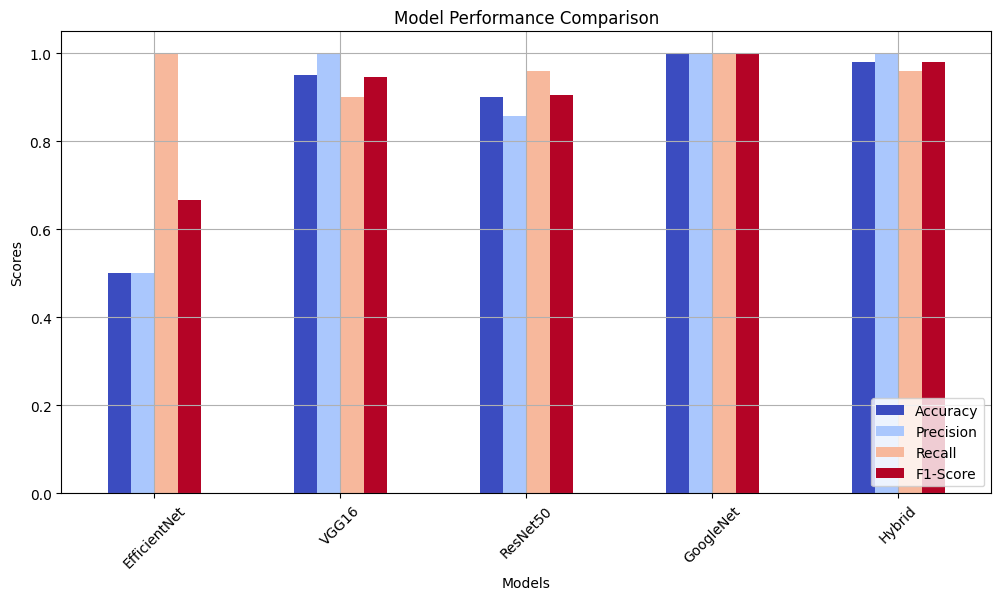

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
results_df.set_index('Model').plot(kind='bar', rot=45, cmap='coolwarm', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
def evaluate_model(model, test_generator, model_name):
    # Check class distribution
    y_true = test_generator.classes
    class_counts = np.bincount(y_true)
    print(f"\nClass Distribution (True Labels) for {model_name}: {class_counts}")

    # Get predictions and check prediction distribution
    y_pred_probs = model.predict(test_generator)
    y_pred = (y_pred_probs > 0.5).astype(int)

    print(f"{model_name} Predictions (First 20): {y_pred[:20].ravel()}")
    print(f"{model_name} True Labels (First 20): {y_true[:20]}")

    # Check if the model is predicting only one class
    unique_preds = np.unique(y_pred)
    print(f"{model_name} Unique Predictions: {unique_preds}")

    if len(unique_preds) == 1:
        print(f"Warning: {model_name} predicts only one class: {unique_preds[0]}")

    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    # Extract relevant metrics
    accuracy = report['accuracy']
    precision = report['1']['precision'] if '1' in report else 0.0
    recall = report['1']['recall'] if '1' in report else 0.0
    f1_score = report['1']['f1-score'] if '1' in report else 0.0

    print(f"{model_name} Evaluation Completed:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}\n")

    return {
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1_score, 4)
    }

# Evaluate all models and collect results
models = ['EfficientNet', 'VGG16', 'ResNet50', 'GoogleNet', 'Hybrid']
results = []

for model_name in models:
    model_path = f'/content/drive/MyDrive/{model_name}_dfu_model.h5'

    if os.path.exists(model_path):
        print(f"Loading model: {model_name} from {model_path}")
        model = tf.keras.models.load_model(model_path)
        results.append(evaluate_model(model, test_generator, model_name))
    else:
        print(f" Model {model_name} not found. Skipping...\n")

# Display Results
results_df = pd.DataFrame(results)
print("Model Evaluation Results:")
print(results_df)


Loading model: EfficientNet from /content/drive/MyDrive/EfficientNet_dfu_model.h5



Class Distribution (True Labels) for EfficientNet: [50 50]
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
EfficientNet Predictions (First 20): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
EfficientNet True Labels (First 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
EfficientNet Unique Predictions: [1]
EfficientNet Evaluation Completed:
Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1-Score: 0.6667

Loading model: VGG16 from /content/drive/MyDrive/VGG16_dfu_model.h5



Class Distribution (True Labels) for VGG16: [50 50]
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step
VGG16 Predictions (First 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
VGG16 True Labels (First 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
VGG16 Unique Predictions: [0 1]
VGG16 Evaluation Completed:
Accuracy: 0.9500, Precision: 1.0000, Recall: 0.9000, F1-Score: 0.9474

Loading model: ResNet50 from /content/drive/MyDrive/ResNet50_dfu_model.h5



Class Distribution (True Labels) for ResNet50: [50 50]
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
ResNet50 Predictions (First 20): [0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0]
ResNet50 True Labels (First 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ResNet50 Unique Predictions: [0 1]
ResNet50 Evaluation Completed:
Accuracy: 0.9000, Precision: 0.8571, Recall: 0.9600, F1-Score: 0.9057

Loading model: GoogleNet from /content/drive/MyDrive/GoogleNet_dfu_model.h5



Class Distribution (True Labels) for GoogleNet: [50 50]
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
GoogleNet Predictions (First 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
GoogleNet True Labels (First 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
GoogleNet Unique Predictions: [0 1]
GoogleNet Evaluation Completed:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Loading model: Hybrid from /content/drive/MyDrive/Hybrid_dfu_model.h5



Class Distribution (True Labels) for Hybrid: [50 50]
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
Hybrid Predictions (First 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Hybrid True Labels (First 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Hybrid Unique Predictions: [0 1]
Hybrid Evaluation Completed:
Accuracy: 0.9800, Precision: 1.0000, Recall: 0.9600, F1-Score: 0.9796

Model Evaluation Results:
          Model  Accuracy  Precision  Recall  F1-Score
0  EfficientNet      0.50     0.5000    1.00    0.6667
1         VGG16      0.95     1.0000    0.90    0.9474
2      ResNet50      0.90     0.8571    0.96    0.9057
3     GoogleNet      1.00     1.0000    1.00    1.0000
4        Hybrid      0.98     1.0000    0.96    0.9796


Generating Grad-CAM for EfficientNet...


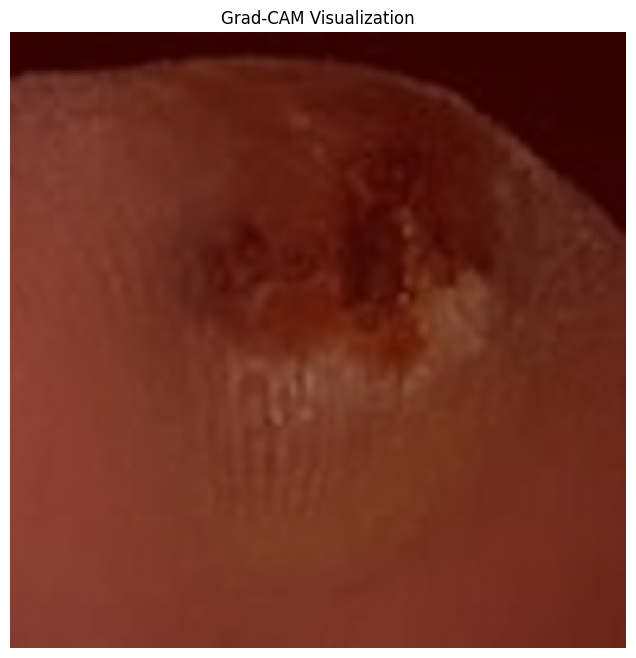

Generating Grad-CAM for VGG16...


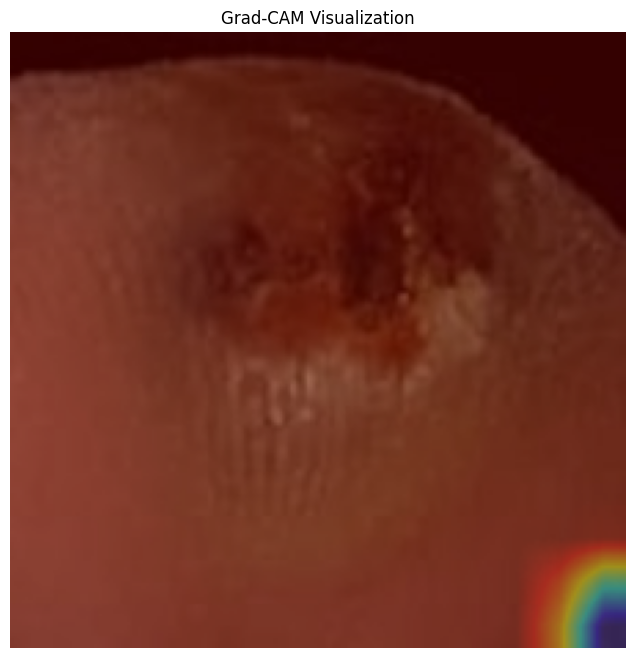

Generating Grad-CAM for ResNet50...


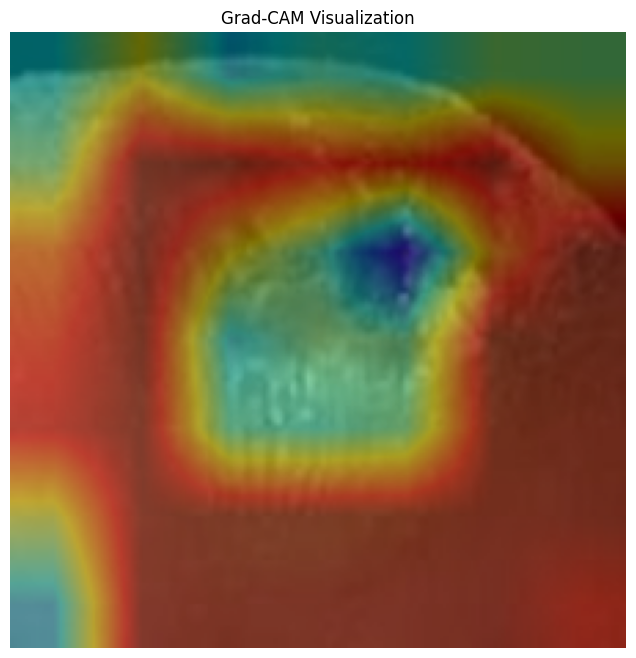

Generating Grad-CAM for GoogleNet...


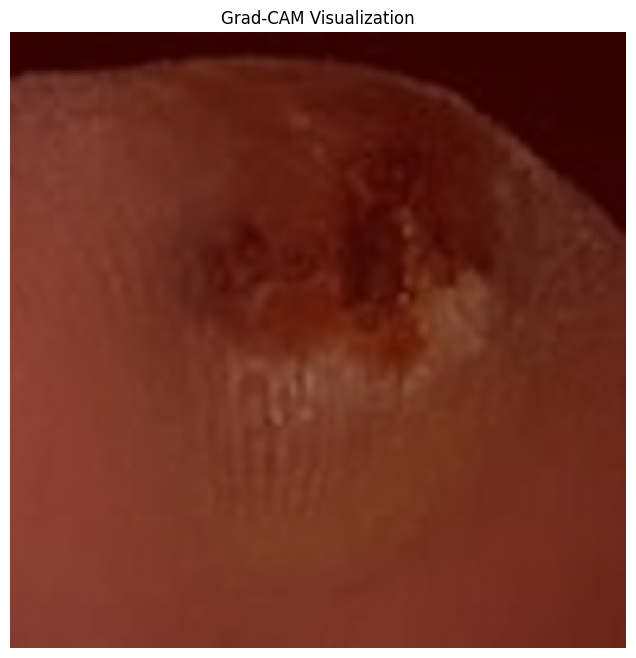

Generating Grad-CAM for Hybrid...


No conv layers found for Hybrid. Skipping...
Grad-CAM visualizations generated for all models.


In [ ]:
# Ensure you import necessary libraries
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to compute Grad-CAM heatmap
def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap[0], 0) / np.max(heatmap[0] + tf.keras.backend.epsilon())
    return heatmap

# Function to overlay heatmap on image
def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()

# Pick a sample image properly
example_img_path = '/content/drive/MyDrive/Roboflow_Dataset/test/Ulcer/473.jpg'

# Check if the generator has data
if len(test_generator) == 0:
    print("Test generator is empty. Check your dataset.")
else:
    # Get the first batch safely
    for model_name in models:
        print(f"Generating Grad-CAM for {model_name}...")
        model_path = f'/content/drive/MyDrive/{model_name}_dfu_model.h5'

        if os.path.exists(model_path):
            model = tf.keras.models.load_model(model_path)

            # Get the last convolutional layer dynamically
            conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name]
            if not conv_layers:
                print(f"No conv layers found for {model_name}. Skipping...")
                continue

            last_conv_layer = conv_layers[-1]

            # Fetch the first image from the test set
            img_array = np.expand_dims(test_generator[0][0][0], axis=0)  # First batch, first image
            heatmap = compute_gradcam(model, img_array, last_conv_layer)
            overlay_heatmap(example_img_path, heatmap)
        else:
            print(f"Model {model_name} not found. Skipping...")

print("Grad-CAM visualizations generated for all models.")


Generating Confusion Matrix for EfficientNet...


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


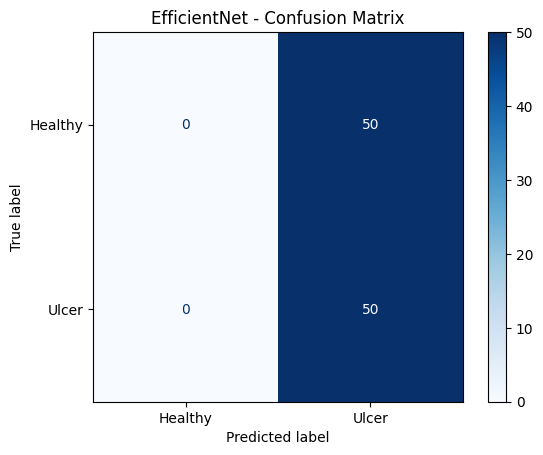

Generating Confusion Matrix for VGG16...


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step


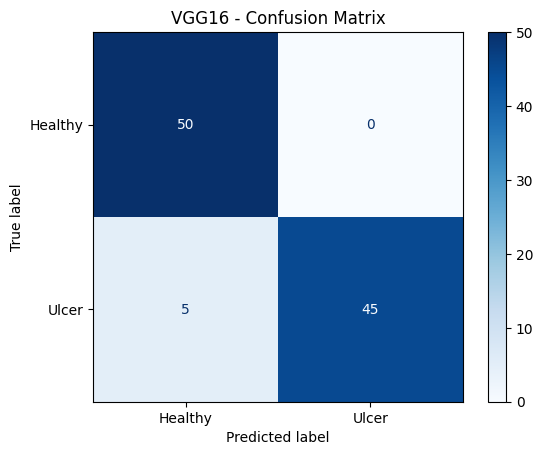

Generating Confusion Matrix for ResNet50...


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


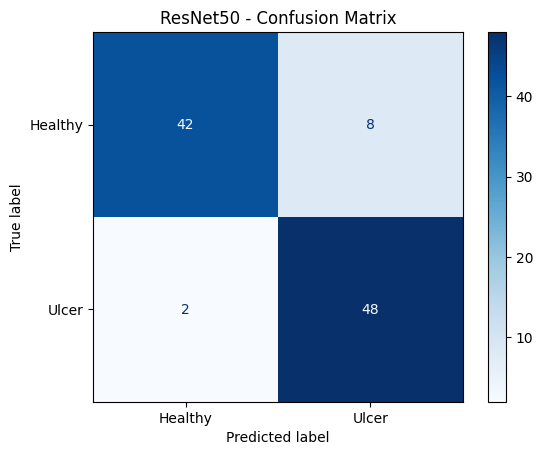

Generating Confusion Matrix for GoogleNet...


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


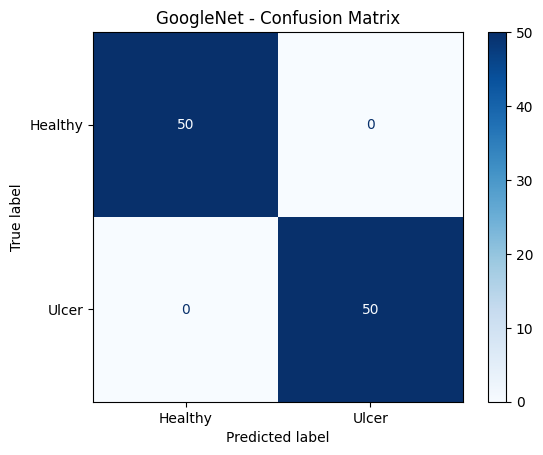

Generating Confusion Matrix for Hybrid...


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


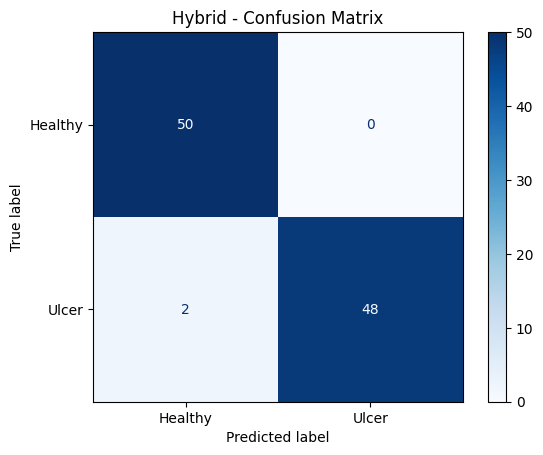

✅ Confusion Matrices generated for all models.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot Confusion Matrix
def plot_confusion_matrix(model, test_generator, model_name):
    y_true = test_generator.classes
    y_pred = (model.predict(test_generator) > 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Ulcer"])
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# Evaluate all models for Confusion Matrix
for model_name in models:
    print(f"Generating Confusion Matrix for {model_name}...")
    model_path = f'/content/drive/MyDrive/{model_name}_dfu_model.h5'

    if os.path.exists(model_path):
        model = tf.keras.models.load_model(model_path)
        plot_confusion_matrix(model, test_generator, model_name)
    else:
        print(f"Model {model_name} not found. Skipping...")

print("✅ Confusion Matrices generated for all models.")
